# Preprocesamiento III

## 5. Dimensiones de las imagenes

### 5.1 Revision de dimensiones

In [23]:
import json
from collections import Counter

In [316]:
def display_image_dimensions_with_stats(coco_json_path):
    """
    Loads a COCO JSON and displays total image count,
    frequency and proportional frequency of each (width, height) dimension.

    Parameters:
        coco_json_path (str): Path to the COCO-format JSON file.
    """
    with open(coco_json_path, 'r', encoding='utf-8') as f:
        coco_data = json.load(f)

    dimensions = [(img['width'], img['height']) for img in coco_data.get('images', [])]
    total_images = len(dimensions)
    dimension_counts = Counter(dimensions)

    print(f"Total number of images: {total_images}\n")
    print("Image dimensions with frequency and proportional frequency:")
    for dim, count in sorted(dimension_counts.items()):
        proportion = (count / total_images) * 100
        print(f"{dim}: {count} images ({proportion:.2f}%)")


In [317]:
display_image_dimensions_with_stats('datasets/unified_dataset/subsets/train.json')

Total number of images: 665

Image dimensions with frequency and proportional frequency:
(640, 640): 183 images (27.52%)
(1536, 2048): 2 images (0.30%)
(2048, 1536): 1 images (0.15%)
(3000, 4000): 381 images (57.29%)
(4000, 3000): 92 images (13.83%)
(6000, 8000): 6 images (0.90%)


In [319]:
display_image_dimensions_with_stats('datasets/unified_dataset/redim/train.json')

Total number of images: 665

Image dimensions with frequency and proportional frequency:
(800, 800): 183 images (27.52%)
(800, 1066): 389 images (58.50%)
(1066, 800): 93 images (13.98%)


### 5.2 Redimensionar imagenes y cajas delimitadoras

In [ ]:
import os
import json
import cv2
from tqdm import tqdm

In [ ]:
def resize_images_and_coco_annotations(
    short_side_target,
    max_long_side,
    coco_json_path,
    images_dir,
    output_images_dir,
    output_json_path
):
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(os.path.dirname(output_json_path), exist_ok=True)

    with open(coco_json_path, 'r', encoding='utf-8') as f:
        coco_data = json.load(f)

    updated_images = []
    updated_annotations = []

    # Create a lookup for annotations by image_id
    annotations_lookup = {}
    for ann in coco_data['annotations']:
        annotations_lookup.setdefault(ann['image_id'], []).append(ann)

    for image_info in tqdm(coco_data['images'], desc="Processing images"):
        file_name = image_info['file_name']
        image_path = os.path.join(images_dir, file_name)
        output_image_path = os.path.join(output_images_dir, file_name)

        image = cv2.imread(image_path)
        if image is None:
            print(f"[WARNING] Could not load image: {file_name}")
            continue

        h, w = image.shape[:2]

        # Determine scale factor
        short_side = min(w, h)
        long_side = max(w, h)

        scale = short_side_target / short_side
        if long_side * scale > max_long_side:
            scale = max_long_side / long_side

        new_w = int(w * scale)
        new_h = int(h * scale)

        # Resize and save image
        resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        cv2.imwrite(output_image_path, resized_image)

        # Update image info
        new_image_info = image_info.copy()
        new_image_info['width'] = new_w
        new_image_info['height'] = new_h
        updated_images.append(new_image_info)

        # Update corresponding annotations
        if image_info['id'] in annotations_lookup:
            for ann in annotations_lookup[image_info['id']]:
                x, y, w_box, h_box = ann['bbox']
                x *= scale
                y *= scale
                w_box *= scale
                h_box *= scale

                new_ann = ann.copy()
                new_ann['bbox'] = [x, y, w_box, h_box]
                new_ann['area'] = w_box * h_box
                updated_annotations.append(new_ann)

    # Assemble updated COCO data
    new_coco = coco_data.copy()
    new_coco['images'] = updated_images
    new_coco['annotations'] = updated_annotations

    with open(output_json_path, 'w', encoding='utf-8') as f_out:
        json.dump(new_coco, f_out, indent=2)


In [ ]:
resize_images_and_coco_annotations(
    800,
    1333,
    'datasets/unified_dataset/subsets/train.json',
    'datasets/unified_dataset/train',
    'datasets/unified_dataset/redim/train',
    'datasets/unified_dataset/redim/train.json'
)

In [ ]:
resize_images_and_coco_annotations(
    800,
    1333,
    'datasets/unified_dataset/subsets/valid.json',
    'datasets/unified_dataset/valid',
    'datasets/unified_dataset/redim/valid',
    'datasets/unified_dataset/redim/valid.json'
)

In [ ]:
resize_images_and_coco_annotations(
    800,
    1333,
    'datasets/unified_dataset/subsets/test.json',
    'datasets/unified_dataset/test',
    'datasets/unified_dataset/redim/test',
    'datasets/unified_dataset/redim/test.json'
)

### 5.3 Validar limites de las cajas delimitadoras

In [320]:
import json

def clamp_coco_bboxes_in_place(coco_json_path):
    """
    Clamps bounding boxes in a COCO annotation file to be within image boundaries.
    Overwrites the original file with fixed values.

    Parameters:
        coco_json_path (str): Path to the COCO-format JSON file.
    """
    with open(coco_json_path, 'r', encoding='utf-8') as f:
        coco = json.load(f)

    # Build image ID → (width, height) mapping
    image_sizes = {
        img['id']: (img['width'], img['height'])
        for img in coco.get('images', [])
    }

    corrected = 0
    for ann in coco.get('annotations', []):
        img_id = ann['image_id']
        if img_id not in image_sizes:
            continue

        img_w, img_h = image_sizes[img_id]
        x, y, w, h = ann['bbox']

        # Clamp x and y
        x = max(0, x)
        y = max(0, y)

        # Clamp width and height so that x + w ≤ img_w and y + h ≤ img_h
        w = max(1, min(w, img_w - x))
        h = max(1, min(h, img_h - y))

        new_bbox = [x, y, w, h]
        if ann['bbox'] != new_bbox:
            ann['bbox'] = new_bbox
            ann['area'] = w * h
            corrected += 1

    # Overwrite the JSON file
    with open(coco_json_path, 'w', encoding='utf-8') as f:
        json.dump(coco, f, indent=2)

    print(f"Clamped {corrected} bounding boxes and updated: {coco_json_path}")


In [321]:
clamp_coco_bboxes_in_place("datasets/unified_dataset/redim/train.json")

Clamped 0 bounding boxes and updated: datasets/unified_dataset/redim/train.json


In [52]:
clamp_coco_bboxes_in_place("datasets/unified_dataset/redim/valid.json")

Clamped 0 bounding boxes and updated: datasets/unified_dataset/redim/valid.json


In [53]:
clamp_coco_bboxes_in_place("datasets/unified_dataset/redim/test.json")

Clamped 0 bounding boxes and updated: datasets/unified_dataset/redim/test.json


## 6. Data Augmentation

### 6.1 Aplicacion

#### i. Solo imagenes aumentadas

In [47]:
import os
import json
import cv2
import albumentations as A
from pathlib import Path
from tqdm import tqdm
from copy import deepcopy

In [48]:
def create_subset_data_augmentation(
    image_folder_path,
    coco_json_path,
    output_image_folder_path,
    output_json_path,
    num_augmentations
):
    """
    Applies data augmentation to images based on COCO annotations and saves the augmented images and new annotations.

    Parameters:
        image_folder_path (str): Path to the original image folder.
        coco_json_path (str): Path to the original COCO JSON annotations.
        output_image_folder_path (str): Directory to save augmented images.
        output_json_path (str): Path to save the new COCO JSON file.
        num_augmentations (int): Number of augmentations to apply per image.
    """
    os.makedirs(output_image_folder_path, exist_ok=True)

    with open(coco_json_path, 'r', encoding='utf-8') as f:
        coco = json.load(f)

    transform = A.Compose([
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.9),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
        A.MotionBlur(blur_limit=3, p=0.3)
    ], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

    new_images = []
    new_annotations = []
    new_image_id = max(img['id'] for img in coco['images']) + 1
    new_annotation_id = max(ann['id'] for ann in coco['annotations']) + 1

    image_id_to_anns = {}
    for ann in coco['annotations']:
        image_id_to_anns.setdefault(ann['image_id'], []).append(ann)

    for img_info in tqdm(coco['images'], desc="Augmenting images"):
        img_path = os.path.join(image_folder_path, img_info['file_name'])
        image = cv2.imread(img_path)
        if image is None:
            continue

        anns = image_id_to_anns.get(img_info['id'], [])
        bboxes = [ann['bbox'] for ann in anns]
        category_ids = [ann['category_id'] for ann in anns]

        if not bboxes:
            continue

        for i in range(1, num_augmentations + 1):
            try:
                transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
            except Exception as e:
                print(f"Skipping augmentation for {img_info['file_name']} due to error: {e}")
                continue

            aug_file_name = f"{Path(img_info['file_name']).stem}_aug-{i}{Path(img_info['file_name']).suffix}"
            aug_path = os.path.join(output_image_folder_path, aug_file_name)

            cv2.imwrite(aug_path, transformed['image'])

            new_images.append({
                "id": new_image_id,
                "file_name": aug_file_name,
                "width": img_info['width'],
                "height": img_info['height']
            })

            for bbox, cat_id in zip(transformed['bboxes'], transformed['category_ids']):
                new_annotations.append({
                    "id": new_annotation_id,
                    "image_id": new_image_id,
                    "category_id": cat_id,
                    "bbox": bbox,
                    "iscrowd": 0,
                    "area": bbox[2] * bbox[3]
                })
                new_annotation_id += 1

            new_image_id += 1

    augmented_coco = {
        "images": new_images,
        "annotations": new_annotations,
        "categories": coco['categories']
    }

    # Create output folder for JSON if it doesn't exist
    os.makedirs(os.path.dirname(output_json_path), exist_ok=True)

    with open(output_json_path, 'w', encoding='utf-8') as f:
        json.dump(augmented_coco, f, indent=2)

    print("Data augmentation complete and saved.")


In [49]:
create_subset_data_augmentation(
    image_folder_path='datasets/unified_dataset/redim/train',
    coco_json_path='datasets/unified_dataset/redim/train.json',
    output_image_folder_path='datasets/unified_dataset/redim/train_augmented',
    output_json_path='datasets/unified_dataset/redim/train_augmented.json',
    num_augmentations=4
)

Augmenting images:   2%|▏         | 12/665 [00:01<01:12,  8.99it/s]

Skipping augmentation for 20231009_193038.jpg due to error: Expected x_max for bbox [0.95671046 0.44984    1.0006254  0.47946668 0.        ] to be in the range [0.0, 1.0], got 1.0006253719329834.
Skipping augmentation for 20231009_193038.jpg due to error: Expected x_max for bbox [0.95671046 0.44984    1.0006254  0.47946668 0.        ] to be in the range [0.0, 1.0], got 1.0006253719329834.
Skipping augmentation for 20231009_193038.jpg due to error: Expected x_max for bbox [0.95671046 0.44984    1.0006254  0.47946668 0.        ] to be in the range [0.0, 1.0], got 1.0006253719329834.
Skipping augmentation for 20231009_193038.jpg due to error: Expected x_max for bbox [0.95671046 0.44984    1.0006254  0.47946668 0.        ] to be in the range [0.0, 1.0], got 1.0006253719329834.


Augmenting images:  21%|██        | 139/665 [00:23<01:28,  5.93it/s]


KeyboardInterrupt: 

#### ii. Train unido

In [54]:
import os
import json
import shutil
from pathlib import Path
from tqdm import tqdm
import cv2
import albumentations as A

In [322]:
def create_subset_data_augmentation_unified(
    image_folder_path,
    coco_json_path,
    output_image_folder_path,
    output_json_path,
    num_augmentations
):
    os.makedirs(output_image_folder_path, exist_ok=True)

    with open(coco_json_path, 'r', encoding='utf-8') as f:
        coco = json.load(f)

    transform = A.Compose([
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.9),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
        A.MotionBlur(blur_limit=3, p=0.3)
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))

    new_images = []
    new_annotations = []
    new_image_id = max(img['id'] for img in coco['images']) + 1
    new_annotation_id = max(ann['id'] for ann in coco['annotations']) + 1

    image_id_to_anns = {}
    for ann in coco['annotations']:
        image_id_to_anns.setdefault(ann['image_id'], []).append(ann)

    # Save original images and annotations
    for img_info in tqdm(coco['images'], desc="Copying original images and annotations"):
        orig_img_path = os.path.join(image_folder_path, img_info['file_name'])
        dest_img_path = os.path.join(output_image_folder_path, img_info['file_name'])

        if not os.path.exists(dest_img_path):
            shutil.copy(orig_img_path, dest_img_path)

        new_images.append({
            "id": img_info['id'],
            "file_name": img_info['file_name'],
            "width": img_info['width'],
            "height": img_info['height']
        })

        for ann in image_id_to_anns.get(img_info['id'], []):
            new_annotations.append({
                "id": ann['id'],
                "image_id": ann['image_id'],
                "category_id": ann['category_id'],
                "bbox": ann['bbox'],
                "iscrowd": ann.get('iscrowd', 0),
                "area": ann['bbox'][2] * ann['bbox'][3]
            })

    # Augment
    for img_info in tqdm(coco['images'], desc="Applying augmentations"):
        img_path = os.path.join(image_folder_path, img_info['file_name'])
        image = cv2.imread(img_path)
        if image is None:
            continue

        anns = image_id_to_anns.get(img_info['id'], [])
        if not anns:
            continue

        img_w, img_h = img_info['width'], img_info['height']

        # Convert COCO [x, y, w, h] to YOLO normalized format
        yolo_bboxes = []
        category_ids = []
        for ann in anns:
            x, y, w, h = ann['bbox']
            x_center = (x + w / 2) / img_w
            y_center = (y + h / 2) / img_h
            w_norm = w / img_w
            h_norm = h / img_h

            def clamp01(v): return max(0.0, min(1.0, v))

            yolo_bboxes.append([
                clamp01(x_center),
                clamp01(y_center),
                clamp01(w_norm),
                clamp01(h_norm)
            ])
            category_ids.append(ann['category_id'])

        for i in range(1, num_augmentations + 1):
            try:
                transformed = transform(image=image, bboxes=yolo_bboxes, category_ids=category_ids)
            except Exception as e:
                print(f"Skipping augmentation for {img_info['file_name']} due to error: {e}")
                continue

            aug_file_name = f"{Path(img_info['file_name']).stem}_aug-{i}{Path(img_info['file_name']).suffix}"
            aug_path = os.path.join(output_image_folder_path, aug_file_name)
            cv2.imwrite(aug_path, transformed['image'])

            new_images.append({
                "id": new_image_id,
                "file_name": aug_file_name,
                "width": img_info['width'],
                "height": img_info['height']
            })

            for bbox, cat_id in zip(transformed['bboxes'], transformed['category_ids']):
                x_center, y_center, w_norm, h_norm = bbox

                w = w_norm * img_w
                h = h_norm * img_h
                x = x_center * img_w - w / 2
                y = y_center * img_h - h / 2

                # Clamp bbox to image bounds
                x = max(0, min(x, img_w - 1))
                y = max(0, min(y, img_h - 1))
                w = max(1, min(w, img_w - x))
                h = max(1, min(h, img_h - y))

                new_annotations.append({
                    "id": new_annotation_id,
                    "image_id": new_image_id,
                    "category_id": cat_id,
                    "bbox": [x, y, w, h],
                    "iscrowd": 0,
                    "area": w * h
                })
                new_annotation_id += 1

            new_image_id += 1

    final_coco = {
        "images": new_images,
        "annotations": new_annotations,
        "categories": coco['categories']
    }

    os.makedirs(os.path.dirname(output_json_path), exist_ok=True)
    with open(output_json_path, 'w', encoding='utf-8') as f:
        json.dump(final_coco, f, indent=2)

    print("Original and augmented images with annotations saved.")


In [323]:
create_subset_data_augmentation_unified(
    image_folder_path='datasets/unified_dataset/redim/train',
    coco_json_path='datasets/unified_dataset/redim/train.json',
    output_image_folder_path='datasets/unified_dataset/redim/train_augmented',
    output_json_path='datasets/unified_dataset/redim/train_augmented.json',
    num_augmentations=4
)

Applying augmentations: 100%|██████████| 665/665 [02:04<00:00,  5.34it/s]


Original and augmented images with annotations saved.


### 6.2 Verificacion de BBOX

In [12]:
import os
from PIL import Image, ImageDraw
from pycocotools.coco import COCO
import random

In [74]:
def save_coco_bboxes_to_images(image_dir, annotation_path, output_dir='output', max_images=None):
    """
    Save images with bounding boxes drawn from COCO annotations.

    Parameters:
        image_dir (str): Directory containing the images.
        annotation_path (str): Full path to the COCO annotation file.
        output_dir (str): Directory to save output images with drawn bounding boxes.
        max_images (int, optional): If provided, randomly selects up to this number of images (without repetition).
    """
    os.makedirs(output_dir, exist_ok=True)
    coco = COCO(annotation_path)
    image_ids = coco.getImgIds()

    if max_images is not None and max_images < len(image_ids):
        image_ids = random.sample(image_ids, max_images)

    for img_id in image_ids:
        img_data = coco.loadImgs(img_id)[0]
        img_path = os.path.join(image_dir, img_data['file_name'])
        output_path = os.path.join(output_dir, img_data['file_name'])

        if not os.path.exists(img_path):
            print(f"[WARNING] Image file not found: {img_path}")
            continue

        image = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(image)

        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        for ann in anns:
            x, y, w, h = ann['bbox']
            #draw.rectangle([x, y, x + w, y + h], outline='red', width=3)
            draw.rectangle([x, y, x + w, y + h], outline='red', width=10)

        image.save(output_path)


In [ ]:
save_coco_bboxes_to_images(
    image_dir='datasets/unified_dataset/redim/train',
    annotation_path='datasets/unified_dataset/redim/train.json',
    output_dir='datasets/unified_dataset/redim/train_bbox_test',
    max_images=50
)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [278]:
save_coco_bboxes_to_images(
    image_dir='datasets/unified_dataset/redim/train',
    annotation_path='datasets/unified_dataset/redim/train.json',
    output_dir='datasets/unified_dataset/redim/train_bbox_test',
)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [294]:
save_coco_bboxes_to_images(
    image_dir='datasets/unified_dataset/redim/test',
    annotation_path='datasets/unified_dataset/redim/test.json',
    output_dir='datasets/unified_dataset/redim/test_bbox_test',
)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [328]:
save_coco_bboxes_to_images(
    image_dir='datasets/unified_dataset/redim/train_augmented',
    annotation_path='datasets/unified_dataset/redim/train_augmented.json',
    output_dir='datasets/unified_dataset/redim/train_augmented_bbox_test',
    max_images=50
)


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


### 6.3 Visualizar Cajas delimitadoras de una imagen

In [79]:
import os
import json
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from pycocotools.coco import COCO

def visualize_coco_bboxes_for_image(image_path, annotation_file):
    """
    Display COCO bounding boxes for a single image.

    Parameters:
        image_path (str): Full path to the image file.
        annotation_file (str): Path to the COCO JSON annotation file.
    """
    coco = COCO(annotation_file)
    image_filename = os.path.basename(image_path)

    # Find image ID in COCO by matching filename
    image_id = None
    for img in coco.dataset['images']:
        if img['file_name'] == image_filename:
            image_id = img['id']
            break

    if image_id is None:
        print(f"Image {image_filename} not found in COCO annotations.")
        return

    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        x, y, w, h = ann['bbox']
        draw.rectangle([x, y, x + w, y + h], outline='red', width=10)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title(image_filename)
    plt.show()


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


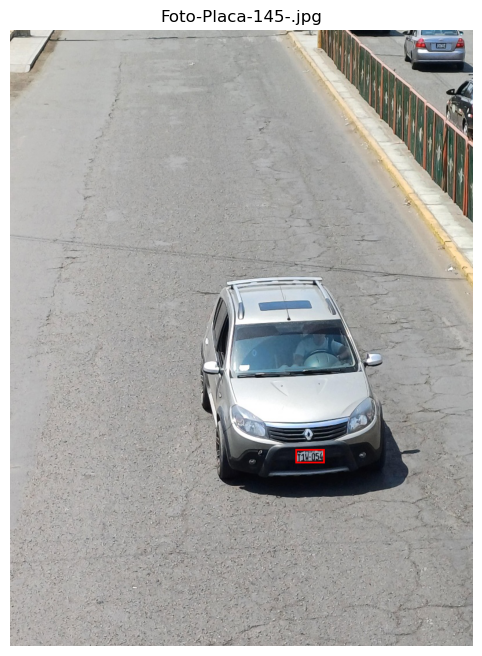

In [73]:
visualize_coco_bboxes_for_image(
    image_path="datasets/unified_dataset/redim/train/Foto-Placa-145-.jpg",
    annotation_file="datasets/unified_dataset/redim/train.json"
)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


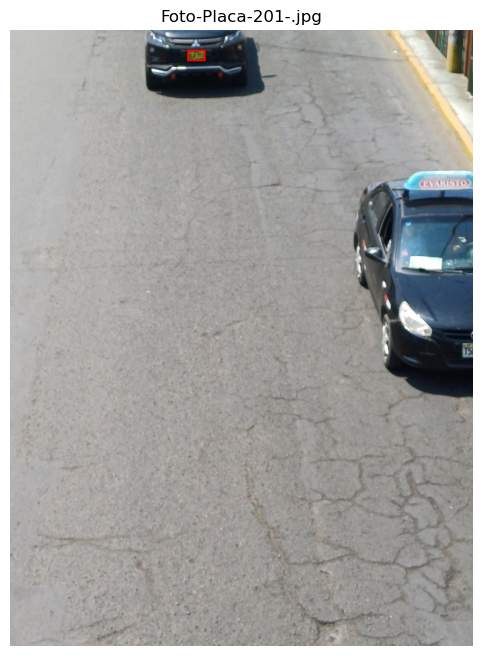

In [72]:
visualize_coco_bboxes_for_image(
    image_path="datasets/unified_dataset/redim/train/Foto-Placa-201-.jpg",
    annotation_file="datasets/unified_dataset/redim/train.json"
)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


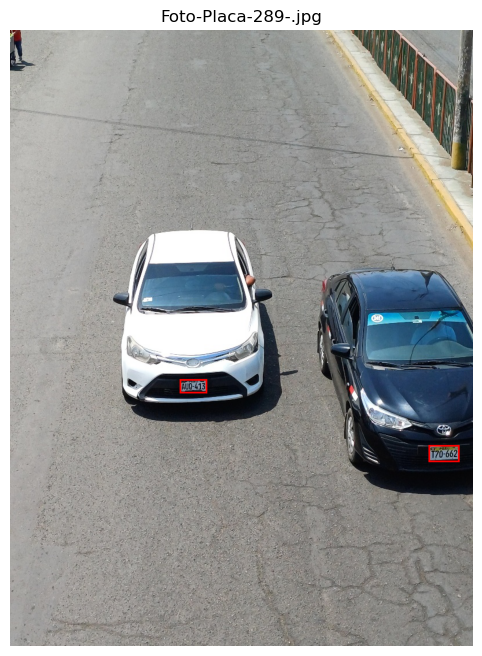

In [71]:
visualize_coco_bboxes_for_image(
    image_path="datasets/unified_dataset/redim/train/Foto-Placa-289-.jpg",
    annotation_file="datasets/unified_dataset/redim/train.json"
)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


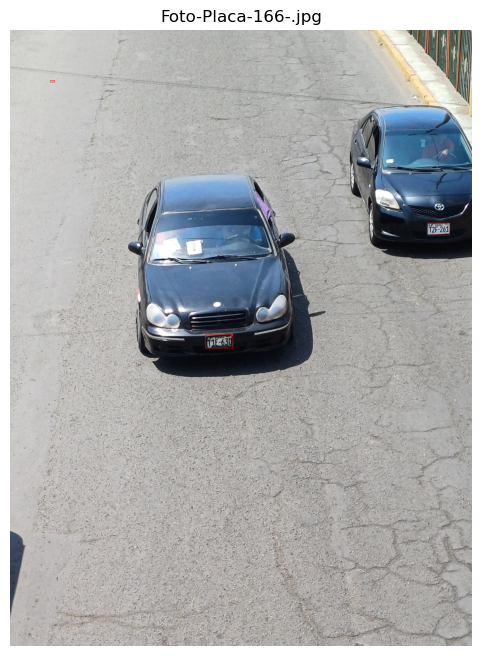

In [77]:
visualize_coco_bboxes_for_image(
    image_path="datasets/unified_dataset/train/Foto-Placa-166-.jpg",
    annotation_file="datasets/unified_dataset/subsets/train.json"
)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


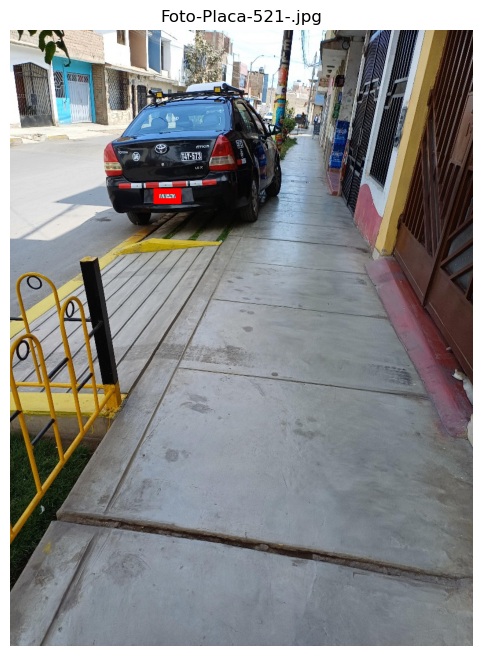

In [280]:
visualize_coco_bboxes_for_image(
    image_path="datasets/unified_dataset/redim/train/Foto-Placa-521-.jpg",
    annotation_file="datasets/unified_dataset/redim/train.json"
)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


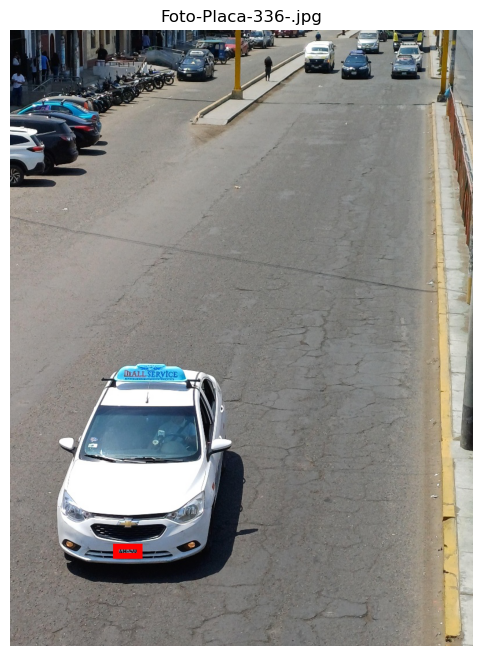

In [293]:
visualize_coco_bboxes_for_image(
    image_path="datasets/unified_dataset/redim/valid/Foto-Placa-336-.jpg",
    annotation_file="datasets/unified_dataset/redim/valid.json"
)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


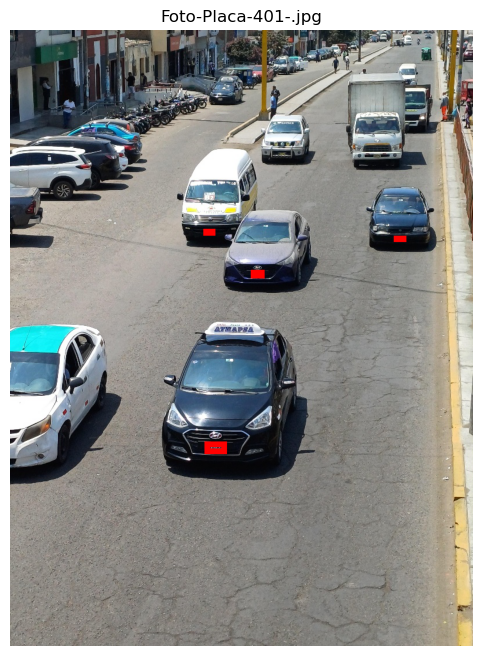

In [314]:
visualize_coco_bboxes_for_image(
    image_path="datasets/unified_dataset/redim/test/Foto-Placa-401-.jpg",
    annotation_file="datasets/unified_dataset/redim/test.json"
)

### 6.4 Cantidad de Imagenes COCO

In [1]:
import json

def count_images_in_coco(coco_json_path):
    """
    Reads a COCO-format JSON file and prints the total number of images.

    Parameters:
        coco_json_path (str): Path to the COCO JSON annotation file.
    """
    with open(coco_json_path, 'r', encoding='utf-8') as f:
        coco_data = json.load(f)

    num_images = len(coco_data.get("images", []))
    print(f"Total number of images: {num_images}")


In [324]:
count_images_in_coco('datasets/unified_dataset/subsets/train.json')

Total number of images: 665


In [325]:
count_images_in_coco('datasets/unified_dataset/train_augmented/train_augmented.json')

Total number of images: 2660


In [326]:
count_images_in_coco('datasets/unified_dataset/subsets/train.json')

Total number of images: 665


In [327]:
count_images_in_coco('datasets/unified_dataset/redim/train_augmented.json')

Total number of images: 3325


### 6.5 Cantidad e Imagenes Path

In [330]:
import os

def count_images_in_folder(folder_path, recursive=False):
    """
    Counts and displays the total number of image files in a folder.

    Parameters:
        folder_path (str): Path to the folder.
        recursive (bool): If True, searches subdirectories as well.
    """
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp', '.gif'}
    count = 0

    if recursive:
        for root, _, files in os.walk(folder_path):
            for file in files:
                if os.path.splitext(file)[1].lower() in image_extensions:
                    count += 1
    else:
        for file in os.listdir(folder_path):
            if os.path.isfile(os.path.join(folder_path, file)) and \
               os.path.splitext(file)[1].lower() in image_extensions:
                count += 1

    print(f"Total image files in folder: {count}")


In [5]:
count_images_in_folder('datasets/unified_dataset/train')

Total image files in folder: 665


In [60]:
count_images_in_folder('datasets/unified_dataset/redim/train_augmented')

Total image files in folder: 3325


In [11]:
count_images_in_folder('datasets/unified_dataset/train_augmented/images')

Total image files in folder: 2660


In [333]:
count_images_in_folder('datasets/unified_dataset/redim/train')

Total image files in folder: 665


In [334]:
count_images_in_folder('datasets/unified_dataset/redim/train_augmented')

Total image files in folder: 3325


### 6.6 Verificar aumento de datos

In [6]:
import os

def check_augmented_images(original_path, augmented_path):
    """
    Compares original and augmented images to find:
    1. Original images missing some of the 4 required augmented versions.
    2. Augmented images with no matching original.

    Parameters:
        original_path (str): Path to folder containing original images.
        augmented_path (str): Path to folder containing augmented images.
    """
    # Get original base names without extensions
    original_bases = {
        os.path.splitext(f)[0] for f in os.listdir(original_path)
        if os.path.isfile(os.path.join(original_path, f))
    }

    # Mapping from original base name to found suffixes
    aug_suffixes = {"_aug-1", "_aug-2", "_aug-3", "_aug-4"}
    aug_tracking = {base: set() for base in original_bases}
    unmatched_augmented = []

    for f in os.listdir(augmented_path):
        name, _ = os.path.splitext(f)
        matched = False
        for suffix in aug_suffixes:
            if name.endswith(suffix):
                base_name = name.replace(suffix, "")
                if base_name in original_bases:
                    aug_tracking[base_name].add(suffix)
                    matched = True
                break
        if not matched:
            unmatched_augmented.append(f)

    print("Images missing augmented versions:")
    for base, suffixes in aug_tracking.items():
        missing = aug_suffixes - suffixes
        if missing:
            print(f"- {base}: missing {sorted(missing)}")

    print("\nAugmented images with no matching original:")
    for aug in unmatched_augmented:
        print(f"- {aug}")


In [9]:
check_augmented_images("datasets/unified_dataset/train", "datasets/unified_dataset/train_augmented/images")

Images missing augmented versions:

Augmented images with no matching original:
